In [1]:
# Imports and constants

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile
import os
import time

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

%matplotlib inline

kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian

# to record runtime
start = time.time()

# Clustering of lat-lon points

In [2]:
# Parameters to control

LAT_COLUMN_NAME = 'latitude'
LON_COLUMN_NAME = 'longitude'

filename = 'waterloo_datathon_datasets/311_service_requests_with_county_with_deltas.csv'

In [3]:
# Load data
df = pd.read_csv(filename, delimiter=',')


In [4]:
# Additional preprocessing work

# df.loc[:, 'norm_inspection_count'] = minmax_scale((df['inspection_count'] / df['population'].astype(float)))
# rich_df = df[df['affluence'] == 'Rich']
# poor_df = df[df['affluence'] == 'Poor']

# print(df.shape[0])
# df.loc[:, 'deltas'] = df[(~df['deltas'].isnull()) & (df['deltas'] > 0)]
# print(df.shape[0])

In [5]:
cluster_start = time.time()
coords = df.as_matrix(columns=[LAT_COLUMN_NAME, LON_COLUMN_NAME])
incomes = df['deltas'].values


In [6]:
# Create clusters

db = KMeans(n_clusters=12, n_jobs=-1).fit(coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
income_clusters = pd.Series([incomes[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 12


In [7]:
cluster_end = time.time()

print("DBSCAN time: %s seconds" % (cluster_end - cluster_start))

DBSCAN time: 3.975809097290039 seconds


In [8]:
centermost_points = db.cluster_centers_
n_points_in_clusters = list(map(len, clusters))
total_number_of_points = len(coords)
mean_incomes = [cluster.mean() for cluster in income_clusters]
normalized_incomes = [float(i)/max(mean_incomes) for i in mean_incomes]
normalized_incomes = minmax_scale(normalized_incomes)

for cluster in income_clusters:
    print(cluster[:10])
    
print(min(normalized_incomes))
print(max(normalized_incomes))

[36.08210648  9.         61.09001157 25.         23.         35.00277778
  8.         99.95689815 41.          7.        ]
[  7.           7.           8.59079861 -18.          10.
   8.67201389   5.9590625    2.11261574   5.9912037    3.        ]
[ 7.         11.         60.82512731 60.7372338   3.          3.
 -0.28827546  6.          6.         10.        ]
[ 60.78184028   6.89363426   8.           8.          15.
   8.9709375    8.         -60.           6.87171296   8.        ]
[-49.          60.76685185   3.07537037 -54.          61.21789352
   8.          61.22523148  15.          14.00087963   6.        ]
[  4.          60.98578704  60.99467593 127.94857639   3.
   3.           2.          35.26137731   3.          61.23616898]
[100.91210648   2.          67.27103009  35.          99.77398148
 -15.          20.          99.94003472  24.          13.        ]
[-45.           2.73104167  24.02177083   4.           9.
  60.73371528 -46.          -6.           4.          99.607870

In [9]:
# Get representative points
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points

,lat,lon
0,40.682979,-73.960484
1,40.857559,-73.857066
2,40.747171,-73.896277
3,40.795004,-73.954684
4,40.736866,-73.988147
5,40.693525,-73.803074
6,40.613063,-73.954508
7,40.844058,-73.912114
8,40.626975,-74.004841
9,40.758568,-73.797461


In [10]:
# Join the original DF to get other data
# result = rep_points.merge(df, left_on=['lat', 'lon'], right_on=[LAT_COLUMN_NAME, LON_COLUMN_NAME])
result = rep_points

In [11]:
# Preview
result.head()

,lat,lon
0,40.682979,-73.960484
1,40.857559,-73.857066
2,40.747171,-73.896277
3,40.795004,-73.954684
4,40.736866,-73.988147


In [12]:
# cluster_start = time.time()
# coords = poor_df.as_matrix(columns=[LAT_COLUMN_NAME, LON_COLUMN_NAME])
# incomes = poor_df['norm_inspection_count'].values

In [13]:
# # Create clusters

# db = KMeans(n_clusters=8, n_jobs=-1).fit(coords)
# cluster_labels = db.labels_
# num_clusters = len(set(cluster_labels))
# clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
# income_clusters = pd.Series([incomes[cluster_labels == n] for n in range(num_clusters)])
# print('Number of clusters: {}'.format(num_clusters))

In [14]:
# cluster_end = time.time()

# print("DBSCAN time: %s seconds" % (cluster_end - cluster_start))

In [15]:
# centermost_points = db.cluster_centers_
# n_points_in_clusters = list(map(len, clusters))
# total_number_of_points = len(coords)
# mean_incomes = [cluster.mean() for cluster in income_clusters]
# normalized_incomes = [float(i)/max(mean_incomes) for i in mean_incomes]
# # def get_centermost_point(cluster):
# #     """
# #     cluster: DataFrame
# #     """
# #     # [[ (lat, lon) ]]
# #     lat_lon_points = [(row[LAT_COLUMN_NAME], row[LON_COLUMN_NAME]) for _, row in cluster.iterrows()]
# #     multi_point = MultiPoint(lat_lon_points)
# #     centroid = (multi_point.centroid.x, multi_point.centroid.y)
# #     centermost_point = min(lat_lon_points, key=lambda point: great_circle(point, centroid).m)
# #     return tuple(centermost_point)
# # centermost_points = clusters.map(get_centermost_point)
# for cluster in income_clusters:
#     print(cluster[:10])

In [16]:
# # Get representative points
# lats, lons = zip(*centermost_points)
# result2 = pd.DataFrame({'lon':lons, 'lat':lats})


In [17]:
# result2.head()

# Geolocation Visualization

In [18]:
# Parameters to control

rcParams['figure.figsize'] = (14,10)    # figure size
fig_margin = 0.1    # margin to leave between points and figure border on all 4 sides, in lat/lon degrees
fig_title = 'Resolution Time of 311 Service Requests in NYC'
fig_length = 42      # height of figure
shapefilename = 'waterloo_datathon_datasets/nyc_shapes/roads'
shapefilename2 = None
# shapefilename = 'waterloo_datathon_datasets/ny_state_shapes/NYS_Civil_Boundaries_SHP/Counties_new'   # name of shapefile
# shapefilename2 = 'waterloo_datathon_datasets/ny_state_shapes/NYS_Civil_Boundaries_SHP/Cities_Towns_new'

In [19]:
descripton = 'Roads and railways of the New York metropolitan area as of October 10, 2016.\nData: OpenStreetMap - openstreetmap.org | Mapzen - mapzen.com\nAuthor: Ramiro Gómez - ramiro.org'
shpfile = os.path.expanduser(shapefilename)
if shapefilename2:
    shpfile2 = os.path.expanduser(shapefilename2)
else:
    shpfile2 = None
#shpfile2 = os.path.expanduser('Toronto-shp/shape/buildings')

fontcolor='#666666'

lllat = result.lat.min() - fig_margin
lllon = result.lon.min() - fig_margin
urlat = result.lat.max() + fig_margin
urlon = result.lon.max() + fig_margin

# total_result = result.append(result2)
# lllat = total_result.lat.min() - fig_margin
# lllon = total_result.lon.min() - fig_margin
# urlat = total_result.lat.max() + fig_margin
# urlon = total_result.lon.max() + fig_margin


In [20]:
print(lllat)
print(lllon)
print(urlat)
print(urlon)

40.49333545309286
-74.10484093539701
40.95755887429246
-73.69010139296421


/home/ubuntu/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/ubuntu/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


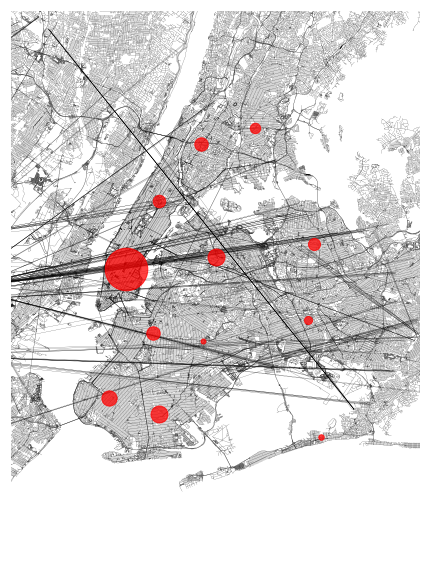

In [21]:
fig = plt.figure()
# ax = fig.add_subplot(111, axisbg='w', frame_on=False)
# fig.suptitle(fig_title, fontsize=20, y=.94, color=fontcolor)
m = Basemap(llcrnrlat = lllat, llcrnrlon=lllon, urcrnrlat=urlat, urcrnrlon=urlon, lat_0=(urlat+lllat)/2, lon_0=(urlon+lllon)/2, resolution='c', projection='mill')

# Avoid border around map.
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)

m.readshapefile(shpfile, 'metro', linewidth=.15)
if shpfile2:
    m.readshapefile(shpfile2, 'metro', linewidth=.15)
    
marker_vals = np.multiply(normalized_incomes, n_points_in_clusters)

for index, row in result.iterrows():
    m.plot(row.lon, row.lat, marker='o', color='red', markersize=5 + 250*(marker_vals[index]/df.shape[0]), alpha = 0.75, latlon=True)

# m.plot(43.6555, -79.3997, marker='o', markersize= 20, alpha = 0.75, latlon=True)
# m.plot(0, 0, marker='o', markersize= 20, alpha = 0.75)
# m.plot(85, 150, marker='o', markersize= 20, alpha = 0.75)

In [22]:
end = time.time()

print("Runtime: %s seconds" % (end - start))

Runtime: 22.164576530456543 seconds
